In [5]:
%matplotlib inline
import datetime as datetime
from sklearn import datasets, linear_model
from sklearn import preprocessing as pre
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import requests
import seaborn as sb
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib

In [6]:
conso = pd.read_csv('conso_train.csv', sep=';')
conso.date = pd.to_datetime(conso.date)
#On ajoute une seconde à la date car elle est sous la forme 22:59:59 jusqu'à fin décembre
conso.date = conso.date + datetime.timedelta(0,1); 
conso.index = conso.date
#Puis elle est sous la forme 22:00:00 à partir de début 2016 donc on re-rajoute une seconde à partir de là
conso2 = conso[2642:]
conso2.date = conso2.date - datetime.timedelta(0,1);
#et on fusionne le tout (using .loc[row_indexer,col_indexer] = value instead)
conso[2642:] = conso2;
conso = conso.drop(['date'], axis=1)

meteo = pd.read_csv('meteo_train.csv', sep=';', usecols=['Date UTC', 'T¬∞ (C)', 'P (hPa)', 'HR (%)', 'P.ros√©e (¬∞C)', 'Visi (km)', 'Vt. moy. (km/h)','Vt. raf. (km/h)', 'Vt. dir (¬∞)','RR 3h (mm)','Neige (cm)','Nebul. (octats)'])
meteo.columns = ['date','temp','pression','hr','pros','visi','vmoy','vraf','vdir','rr','neige','nebul']
#Pour éviter les glitchs sur la date de météo
meteo.date = meteo.date.str.replace('h', ':')
meteo.date = pd.to_datetime(meteo.date, format='%d/%m/%y %H:%M')
meteo.date = meteo.date.dt.strftime('%Y-%m-%d %H:%M:%S')
meteo.index = meteo.date
meteo = meteo.drop(['date'], axis=1);

#Finalement on merge les deux tables pour en obtenir une seule contenant tous les données dont nous avons besoin
df = pd.merge(conso, meteo, right_index = True, left_index = True)
df = df.drop(['rr'], axis=1)
df = df.drop(['neige'], axis=1)
df = df.drop(['nebul'], axis=1)
#On ajoute le jour de la semaine et la semaine de l'année dans nos prédictions
df['weekday'] = df.index.weekday
df['week'] = df.index.week

#On instancie une nouvelle colonne jour
df['jour'] = 0

#On crée des tableau pour les jours, mois et heures
jour=[]
mois=['janvier','fevrier','mars','avril','mai','juin','juillet','aout','septembre','octobre','novembre','decembre']
heures=['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23']

tab_mois = []
tab_heures = []
#On va créer des tableau de mois et heures de manières à les rajouter en tant que colonnes à notre dataframe
for i in range(len(mois)):
    tab = mois[i]
    tab = []
    tab_mois.append(tab)
    
for i in range(len(heures)):
    tab = heures[i]
    tab = []
    tab_heures.append(tab)
    
date = df.index
#On va réaliser le traitement sur la data permettant d'ajouter à la dataframe le jour, le mois et l'heure
for i in range(len(df)):
    dt = date[i]
    dt_month = dt.month
    dt_hour = dt.hour
    dt_day = dt.day
    for j in range(len(mois)):
        if dt_month == j+1:
            tab_mois[j].append(1)
        else:
            tab_mois[j].append(0)
            
    if dt_hour >= 7 and dt_hour <= 20:
        jour.append(1)
    else:
        jour.append(0)
        
    for k in range(len(heures)):
        if dt_hour == k:
            tab_heures[k].append(1)
        else:
            tab_heures[k].append(0)

#On finit par créer les colonnes dans la dataframe grâce au tableau traités précédemmenrt
for i in range(len(mois)):
    df[mois[i]] = tab_mois[i]
    
for i in range(len(heures)):
    df[heures[i]] = tab_heures[i]
          
df['jour'] = jour

df = df.dropna(axis = 0, how ='any')

#On divise la dataframe en deux dataframe, une d'entrainement et une de test
train_conso = df[0:2803]
test_conso = df[2804:2860]

D:\Programmes\Anaconda\lib\site-packages\pandas\core\generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Mean squared error: 16333.54
Variance score: -0.50


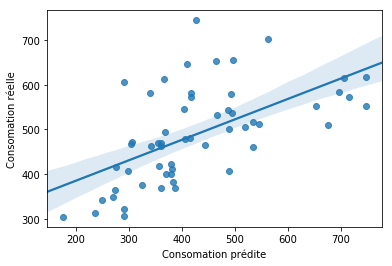

In [7]:
# On récupère les colonnes avec lesquels on souhaite faire la prédiction
names=['weekday','week','jour','temp','pression','hr','pros','visi','vmoy','vraf','vdir']+mois+heures
elts_train=[]
elts_test=[]

#On va créer une liste des valeurs d'entrainement
for i in range(len(train_conso)):
    conso_interm = []
    for j in range(len(names)):
        conso_interm.append(train_conso[names[j]][i])
    elts_train.append(conso_interm)
    
#On va créer une liste des valeurs de test    
for i in range(len(test_conso)):
    conso_interm = []
    for j in range(len(names)):
        conso_interm.append(test_conso[names[j]][i])
    elts_test.append(conso_interm)
    
#On choisit la méthode de regression que l'on souhaite utilisé   
reg_linear = linear_model.LinearRegression()

#On fit les données d'entrainement 
reg_linear.fit(elts_train, [[x] for x in train_conso.puissance])

#On prédit des valeurs de puissance grâce aux valeurs de test 
conso_y_pred_linear = reg_linear.predict(elts_test)

#On réalise un scatter plot des données prédites
sb.regplot(conso_y_pred_linear, test_conso.puissance, scatter = True)
plt.xlabel("Consomation prédite")
plt.ylabel("Consomation réelle")

#On calcule le MSE de la consommation prédite par rapport à la consommations réelle
print("Mean squared error: %.2f"
      % mean_squared_error(test_conso.puissance, conso_y_pred_linear))

#On calcule le score de variance, indicateur de la précision de prédiction
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(test_conso.puissance, conso_y_pred_linear))

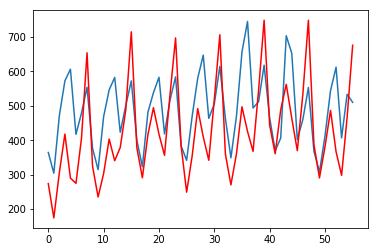

Mean squared error: 16333.54
Variance score: -0.50


In [8]:
#On plot les valeurs prédites (En rouge) par rapport aux valeurs réelles (En bleu)
plt.plot([[x] for x in test_conso.puissance])
plt.plot(conso_y_pred_linear, color ='RED')
plt.show()


#On calcule le MSE de la consommation prédite par rapport à la consommations réelle
print("Mean squared error: %.2f"
      % mean_squared_error(test_conso.puissance, conso_y_pred_linear))

#On calcule le score de variance, indicateur de la précision de prédiction
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(test_conso.puissance, conso_y_pred_linear))

Mean squared error: 3500.61
Variance score: 0.68


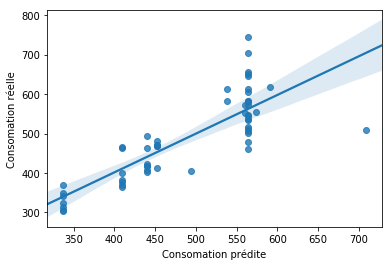

In [9]:
#On choisit la méthode de regression que l'on souhaite utilisé   
reg_tree = DecisionTreeRegressor(max_depth = 10) 

#On fit les données d'entrainement 
reg_tree.fit(elts_train, [[x] for x in train_conso.puissance])

#On prédit des valeurs de puissance grâce aux valeurs de test 
conso_y_pred_tree = reg_tree.predict(elts_test)

#On réalise un scatter plot des données prédites
sb.regplot(conso_y_pred_tree, test_conso.puissance, scatter = True)
plt.xlabel("Consomation prédite")
plt.ylabel("Consomation réelle")

#On calcule le MSE de la consommation prédite par rapport à la consommations réelle
print("Mean squared error: %.2f"
      % mean_squared_error(test_conso.puissance, conso_y_pred_tree))

#On calcule le score de variance, indicateur de la précision de prédiction
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(test_conso.puissance, conso_y_pred_tree))

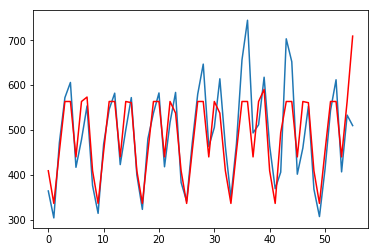

Mean squared error: 3500.61
Variance score: 0.68


In [10]:
#On plot les valeurs prédites (En rouge) par rapport aux valeurs réelles (En bleu)
plt.plot([[x] for x in test_conso.puissance])
plt.plot(conso_y_pred_tree, color ='RED')
plt.show()


#On calcule le MSE de la consommation prédite par rapport à la consommations réelle
print("Mean squared error: %.2f"
      % mean_squared_error(test_conso.puissance, conso_y_pred_tree))

#On calcule le score de variance, indicateur de la précision de prédiction
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(test_conso.puissance, conso_y_pred_tree))

D:\Programmes\Anaconda\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Mean squared error: 2971.36
Variance score: 0.73


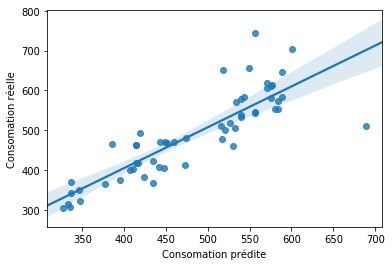

In [28]:
#On choisit la méthode de regression que l'on souhaite utilisé  
reg_forest = RandomForestRegressor(max_depth = 100)

#On fit les données d'entrainement 
reg_forest.fit(elts_train, [[x] for x in train_conso.puissance])

#On prédit des valeurs de puissance grâce aux valeurs de test 
conso_y_pred_forest = reg_forest.predict(elts_test)

#On réalise un scatter plot des données prédites
sb.regplot(conso_y_pred_forest, test_conso.puissance, scatter = True)
plt.xlabel("Consomation prédite")
plt.ylabel("Consomation réelle")

#On calcule le MSE de la consommation prédite par rapport à la consommations réelle
print("Mean squared error: %.2f"
      % mean_squared_error(test_conso.puissance, conso_y_pred_forest))

#On calcule le score de variance, indicateur de la précision de prédiction
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(test_conso.puissance, conso_y_pred_forest))

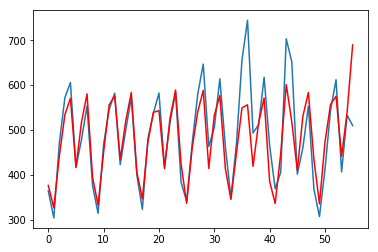

Mean squared error: 2971.36
Variance score: 0.73


In [29]:
#On plot les valeurs prédites (En rouge) par rapport aux valeurs réelles (En bleu)
plt.plot([[x] for x in test_conso.puissance])
plt.plot(conso_y_pred_forest, color ='RED')
plt.show()
print("Mean squared error: %.2f"
      % mean_squared_error(test_conso.puissance, conso_y_pred_forest))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(test_conso.puissance, conso_y_pred_forest))